# Daylio data analysis (10/29/23 - 7/21/24)

Below I analyze my daylio entry data, which consistent of a bunch of 1/0 (true/false) check boxes and an overall mood (predictor variable) for every day for the past ~9 months. To do this I clean up the data a bit and then run some linear regressions/feature importance (stepwise and lasso regression) to see what affects my mood (same day mood - since I log at night, and later the next day mood predictors).

## My main takeaways
1. The most important activity for my overall mood is exercise, then walking 30m and then date/quality time with my partner and cat cuddle time (in that order roughly). So being sedentary and isolated is bad for me.
2. This might seem obvious, but I like Saturdays a LOT (the most by far). Then comes Sundays, surprisingly Mondays, and Fridays. My least favorite are Thursdays, Tuesdays, and Wednesdays - which are probably related to work/autonomy. Keep in mind this is holding activities constant in the regression, but obv with more free time I have more ability to choose what I do.
3. I had a really good June (got off lexapro after 3 years, seems like a good decision - might be reverse causality, ie good mood -> okay to get off lexapro SSRI) and a really tough November (when I started the data, so it makes sense that having a hard time might kick off that habit of tracking my mood).
4. The most predictive outcome for my NEXT day (ie 1 above is for the same date since I log data at might) - is sleep before 1230am (then stop gaming by 11pm), which fits/makes a lot of intuitive sense (especially because I only enter it the morning after - so it's like a nice start to my day that I went to bed early the previous day!), but not much else matters - good to know!
5. Related to 1 above, surprisingly a lot of variables I included didn't really matter: doomscrolling, sugar intake, gaming/friends, or eating veggies. Granted, veggies are good for health even if not immediate mood, and the sugar intake take doesn't go back very far (I added it a month ago) and doomscrolling isn't as far back either (usually more of a symptom of a rough day).

Note: This is not causality or a prediction per se, this is showing the average contribution of inputs (independent variables) on outputs (dependent variables) - ie regression coeffients (and their standard errors/p-values/statistical significance).

### Data upload, exploration, and cleanup (feature engineering)

In [40]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [41]:
import pandas as pd
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/daylio_export_2024_07_22.csv')

In [42]:
## Each row is a day I recorded (so 267 days).
print(df.shape)
df.head()

(267, 8)


,full_date,date,weekday,time,mood,activities,note_title,note
0,2024-07-21,July 21,Sunday,11:16 PM,Solid,bed by 1230 | walk/move body 30m | friends/gam...,NaN,NaN
1,2024-07-20,July 20,Saturday,11:30 PM,Solid,bed by 1230 | stop gaming before 11 | walk/mov...,NaN,NaN
2,2024-07-19,July 19,Friday,11:33 PM,Meh,bed by 1230 | walk/move body 30m | friends/gam...,NaN,NaN
3,2024-07-18,July 18,Thursday,11:34 PM,Meh,stop gaming before 11 | walk/move body 30m | d...,NaN,NaN
4,2024-07-17,July 17,Wednesday,9:30 AM,Meh,stop gaming before 11 | walk/move body 30m | f...,NaN,NaN


In [43]:
## droppng notes/note details, etc as well as time/date
df2 = df[['full_date','weekday','mood','activities']]

In [44]:
df2.head()

,full_date,weekday,mood,activities
0,2024-07-21,Sunday,Solid,bed by 1230 | walk/move body 30m | friends/gam...
1,2024-07-20,Saturday,Solid,bed by 1230 | stop gaming before 11 | walk/mov...
2,2024-07-19,Friday,Meh,bed by 1230 | walk/move body 30m | friends/gam...
3,2024-07-18,Thursday,Meh,stop gaming before 11 | walk/move body 30m | d...
4,2024-07-17,Wednesday,Meh,stop gaming before 11 | walk/move body 30m | f...


In [45]:
## Data cleanup

# dependent variable from categorical to numeric (since mood is effectively 0-4 here)
df2.mood[df2.mood == 'Bleh'] = int(1)
df2.mood[df2.mood == 'Meh'] = int(2)
df2.mood[df2.mood == 'Solid'] = int(3)
df2.mood[df2.mood == 'Great!'] = int(4)

## Breakout month to hold that constant in analysis (ie in case I just had a good/bad month, etc)
import datetime as dt
df2['monyr']= pd.to_datetime(df['full_date']).dt.to_period('M')

<ipython-input-45-b513fdf0afc4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.mood[df2.mood == 'Bleh'] = int(1)
<ipython-input-45-b513fdf0afc4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.mood[df2.mood == 'Meh'] = int(2)
<ipython-input-45-b513fdf0afc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.mood[df2.mood == 'Solid'] = int(3)
<ipython-input-45-b513fdf0afc4>:7: SettingWithCopyWarning: 
A value is trying to b

In [46]:
df2.head()

,full_date,weekday,mood,activities,monyr
0,2024-07-21,Sunday,3,bed by 1230 | walk/move body 30m | friends/gam...,2024-07
1,2024-07-20,Saturday,3,bed by 1230 | stop gaming before 11 | walk/mov...,2024-07
2,2024-07-19,Friday,2,bed by 1230 | walk/move body 30m | friends/gam...,2024-07
3,2024-07-18,Thursday,2,stop gaming before 11 | walk/move body 30m | d...,2024-07
4,2024-07-17,Wednesday,2,stop gaming before 11 | walk/move body 30m | f...,2024-07


mood
3    157
2     87
1     12
4     11
Name: count, dtype: int64


<Axes: >

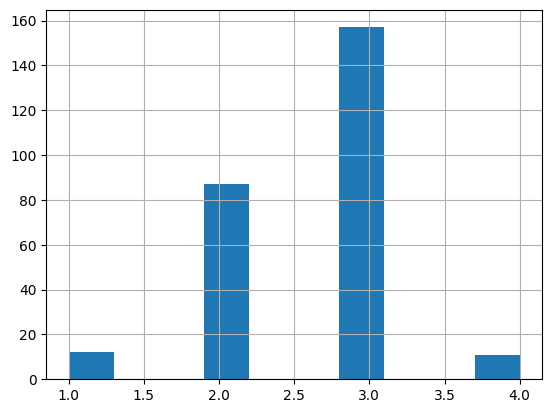

In [94]:
## Check predictive variables
## Note: while mood is a categorical variable (ie meh, solid, great!), effectively I can turn it into a numerical variabl (0-4)
## I have a 0 ('Empty') mood, but didn't have an instance of it during this 9m period.
# However, I could expand/emphasis (or jsut re-sample if imbalanced) on higher moods, eg if 'Great' was 10 instead of a 4.
print(df2['mood'].value_counts())
df2.mood.hist()
# Mostly 3's ('solid') by quite a bit (~2x) and only 11-12 'bleh' (1) or 'Great!' (4) - so the data is a bit imbalanced, might do some re-sampling in the future

In [49]:
df2.activities[0]

'bed by 1230 | walk/move body 30m | friends/gamed | date/quality time | ate vegetables | <= 3 desserts (sugar)'

In [50]:
## Get dummy variables for day of week + month
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(df2[['weekday','monyr']])
encoded_feature_names = encoder.get_feature_names_out(['weekday','monyr'])
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

df3 = pd.concat([df2, encoded_df], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [51]:
# Drop categorical variables since I have dummies now
df4 = df3.drop(['full_date','weekday','monyr'],axis=1)

In [52]:
df4.columns = df4.columns.str.lower()

In [53]:
df4.head()

,mood,activities,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,monyr_2023-10,monyr_2023-11,monyr_2023-12,monyr_2024-01,monyr_2024-02,monyr_2024-03,monyr_2024-04,monyr_2024-05,monyr_2024-06,monyr_2024-07
0,3,bed by 1230 | walk/move body 30m | friends/gam...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,3,bed by 1230 | stop gaming before 11 | walk/mov...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,bed by 1230 | walk/move body 30m | friends/gam...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,stop gaming before 11 | walk/move body 30m | d...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,stop gaming before 11 | walk/move body 30m | f...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [54]:
## Clean up activities column by splitting it out and making into separate dummy vars
df_split = df['activities'].str.split(' \| ', expand=True)

In [55]:
df_split.head(10)

,0,1,2,3,4,5,6,7,8,9
0,bed by 1230,walk/move body 30m,friends/gamed,date/quality time,ate vegetables,<= 3 desserts (sugar),None,None,None,None
1,bed by 1230,stop gaming before 11,walk/move body 30m,exercised/sweat,friends/gamed,date/quality time,ate vegetables,No doomscroll,<= 3 desserts (sugar),None
2,bed by 1230,walk/move body 30m,friends/gamed,date/quality time,ate vegetables,cat cuddle time,<= 3 desserts (sugar),None,None,None
3,stop gaming before 11,walk/move body 30m,date/quality time,ate vegetables,cat cuddle time,None,None,None,None,None
4,stop gaming before 11,walk/move body 30m,friends/gamed,date/quality time,ate vegetables,<= 3 desserts (sugar),None,None,None,None
5,bed by 1230,stop gaming before 11,friends/gamed,ate vegetables,None,None,None,None,None,None
6,walk/move body 30m,exercised/sweat,friends/gamed,date/quality time,ate vegetables,cat cuddle time,<= 3 desserts (sugar),None,None,None
7,bed by 1230,stop gaming before 11,walk/move body 30m,friends/gamed,date/quality time,ate vegetables,cat cuddle time,None,None,None
8,bed by 1230,walk/move body 30m,exercised/sweat,friends/gamed,date/quality time,ate vegetables,No doomscroll,<= 3 desserts (sugar),None,None
9,bed by 1230,stop gaming before 11,walk/move body 30m,exercised/sweat,friends/gamed,date/quality time,ate vegetables,cat cuddle time,No doomscroll,<= 3 desserts (sugar)


In [56]:
## Data format notes:
## Entries are stored out of order (but not randomly) - ie all the 'none' or de-selected items are at the end.
## Ideally these 'None' selections would be in the same order and each column could be one type of entry (e.g. no doomscroll) is
## one column that is there if selected, and None if not (ie easy to make a dummy variable for a regression).
## Fortunately, it seems like the data is at least consistent going backwards - so it backfills history as 0 and keeps names the same.

In [57]:
## All 10 entries example
print(sorted(list(df_split.iloc[9])))

## Uniques in full dataframe
un_list = list(pd.unique(df_split.values.ravel()))
un_list.remove(None)
full_list = sorted(un_list)
print(full_list)

['<= 3 desserts (sugar)', 'No doomscroll', 'ate vegetables', 'bed by 1230', 'cat cuddle time', 'date/quality time', 'exercised/sweat', 'friends/gamed', 'stop gaming before 11', 'walk/move body 30m']
['<= 3 desserts (sugar)', 'No doomscroll', 'ate vegetables', 'bed by 1230', 'cat cuddle time', 'date/quality time', 'exercised/sweat', 'friends/gamed', 'stop gaming before 11', 'walk/move body 30m']


In [58]:
## All activities
full_list

## variable explanations:
## Sugar: <= 3 desserts (sugar) -> less than 3 desserts (or comparable sugar), so 1 = less sugar, 0 = more sugar.
## No doomscroll: doomscroll -> didn't doomscroll > 5min on phone.
## veggies: ate vegetables -> at least 1 meal had vegetables (good for digestion/vitamins!)
## bedby1230: bed by 1230 -> go to bed by 12:30 (or very close) - mainly avoid goign to bed after 1am since it messes up my sleep
## cat: cat cuddle time -> cuddle with my new kitty/bonding time
## date: date/quality time -> date with my spouse, whether a walk, movie, good deep chat, etc etc
## exercise: exercised/sweat -> work out and sweat (mostly yoga, sometimes gym, etc), usually only if >30min or at least 10m if brief like pushups, etc
## friends_gamed: friends/gamed -> most vague, I put if I had 'play' time with friends or played video games, light fun
## stopgamingby11: stop gaming before 11 -> stop gaming too late, sort of an input to sleep in practice.
## walk30m: walk/move body 30 -> Go for a walk of some kind, ideally >30min but at least a short 15min walk.

## Note, 1 is good for all of these and 0 is bad. Meaning 1 = no doomscroll, 0 = doomscrolled.
## So an ideal day would have more 1s.

['<= 3 desserts (sugar)',
 'No doomscroll',
 'ate vegetables',
 'bed by 1230',
 'cat cuddle time',
 'date/quality time',
 'exercised/sweat',
 'friends/gamed',
 'stop gaming before 11',
 'walk/move body 30m']

In [59]:
## Split activities into their own rows of 0/1

df_split2 = df_split.copy()
for x in range(0,df_split.shape[0]):
  updated_row = []
  the_row = df_split.iloc[x]
  row_values = list(the_row)
  #print(x)
  #print(row_values)
  for i,z in enumerate(full_list):
    if(z in row_values):
      updated_row.append(1)
      #print(z)
    else:
      updated_row.append(0)
    #print(updated_row)
  df_split2.iloc[x] = updated_row

print(df_split2)

     0  1  2  3  4  5  6  7  8  9
0    1  0  1  1  0  1  0  1  0  1
1    1  1  1  1  0  1  1  1  1  1
2    1  0  1  1  1  1  0  1  0  1
3    0  0  1  0  1  1  0  0  1  1
4    1  0  1  0  0  1  0  1  1  1
..  .. .. .. .. .. .. .. .. .. ..
262  0  0  1  1  0  0  1  1  1  0
263  0  0  1  1  0  1  0  0  1  0
264  0  0  1  1  0  1  0  1  1  0
265  0  0  1  1  0  0  1  1  1  0
266  0  0  1  0  0  1  0  1  0  0

[267 rows x 10 columns]


In [60]:
df_split2.columns = ['sugar','doomscroll','veggies','bedby1230','cat','date','exercise','friends_gamed','stopgamingby11','walk30m']
df_split2.head()

,sugar,doomscroll,veggies,bedby1230,cat,date,exercise,friends_gamed,stopgamingby11,walk30m
0,1,0,1,1,0,1,0,1,0,1
1,1,1,1,1,0,1,1,1,1,1
2,1,0,1,1,1,1,0,1,0,1
3,0,0,1,0,1,1,0,0,1,1
4,1,0,1,0,0,1,0,1,1,1


In [61]:
pd.set_option('display.max_columns', None)
df_combined = pd.concat([df4, df_split2], axis=1)
df_combined.head()

,mood,activities,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,monyr_2023-10,monyr_2023-11,monyr_2023-12,monyr_2024-01,monyr_2024-02,monyr_2024-03,monyr_2024-04,monyr_2024-05,monyr_2024-06,monyr_2024-07,sugar,doomscroll,veggies,bedby1230,cat,date,exercise,friends_gamed,stopgamingby11,walk30m
0,3,bed by 1230 | walk/move body 30m | friends/gam...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,0,1,0,1,0,1
1,3,bed by 1230 | stop gaming before 11 | walk/mov...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,0,1,1,1,1,1
2,2,bed by 1230 | walk/move body 30m | friends/gam...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,1,1,0,1,0,1
3,2,stop gaming before 11 | walk/move body 30m | d...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,1,1,0,0,1,1
4,2,stop gaming before 11 | walk/move body 30m | f...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,1,0,1,1,1


In [64]:
## Check a few rows compared to the dummy vars above (out of order/diff names but 'ate vegetables = 1 for 'veggies' column)
## Looks good!
print(df_combined.activities[0])
print(df_combined.activities[1])
print(df_combined.activities[2])

bed by 1230 | walk/move body 30m | friends/gamed | date/quality time | ate vegetables | <= 3 desserts (sugar)
bed by 1230 | stop gaming before 11 | walk/move body 30m | exercised/sweat | friends/gamed | date/quality time | ate vegetables | No doomscroll | <= 3 desserts (sugar)
bed by 1230 | walk/move body 30m | friends/gamed | date/quality time | ate vegetables | cat cuddle time | <= 3 desserts (sugar)


In [65]:
## Y mood is dependent/predictor variable
## X's month, day of week, activities are independent variables (all dummy vars)

Xd = df_combined.drop(['activities','mood'],axis=1)
X = Xd.apply(pd.to_numeric, errors='coerce')
Yd = df_combined.mood
Y = Yd.apply(pd.to_numeric, errors='coerce')

In [66]:
X.head()

,weekday_friday,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,monyr_2023-10,monyr_2023-11,monyr_2023-12,monyr_2024-01,monyr_2024-02,monyr_2024-03,monyr_2024-04,monyr_2024-05,monyr_2024-06,monyr_2024-07,sugar,doomscroll,veggies,bedby1230,cat,date,exercise,friends_gamed,stopgamingby11,walk30m
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,0,1,0,1,0,1
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,1,1,0,1,1,1,1,1
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,1,1,1,0,1,0,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,1,1,0,0,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,1,0,1,1,1


In [67]:
Y.head()

0    3
1    3
2    2
3    2
4    2
Name: mood, dtype: int64

In [68]:
#print(X.isnull().sum()) # No nulls
#print(X.info()) # Some dtypes were objects, so made all float.
#print(X.describe())
print(X.sum()) ## easier since it's all binary to see counts for totals

weekday_friday        38.0
weekday_monday        38.0
weekday_saturday      38.0
weekday_sunday        39.0
weekday_thursday      38.0
weekday_tuesday       38.0
weekday_wednesday     38.0
monyr_2023-10          3.0
monyr_2023-11         30.0
monyr_2023-12         31.0
monyr_2024-01         31.0
monyr_2024-02         29.0
monyr_2024-03         31.0
monyr_2024-04         30.0
monyr_2024-05         31.0
monyr_2024-06         30.0
monyr_2024-07         21.0
sugar                 15.0
doomscroll            40.0
veggies              247.0
bedby1230            215.0
cat                  132.0
date                 156.0
exercise              93.0
friends_gamed        210.0
stopgamingby11       217.0
walk30m              237.0
dtype: float64


In [69]:
## I realize I don't actually have to split this into train/test because I'm not trying to predict
## but instead trying to interpret and determine feature importance

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# print(y_train.shape)
# print(X_train.shape)

<Axes: >

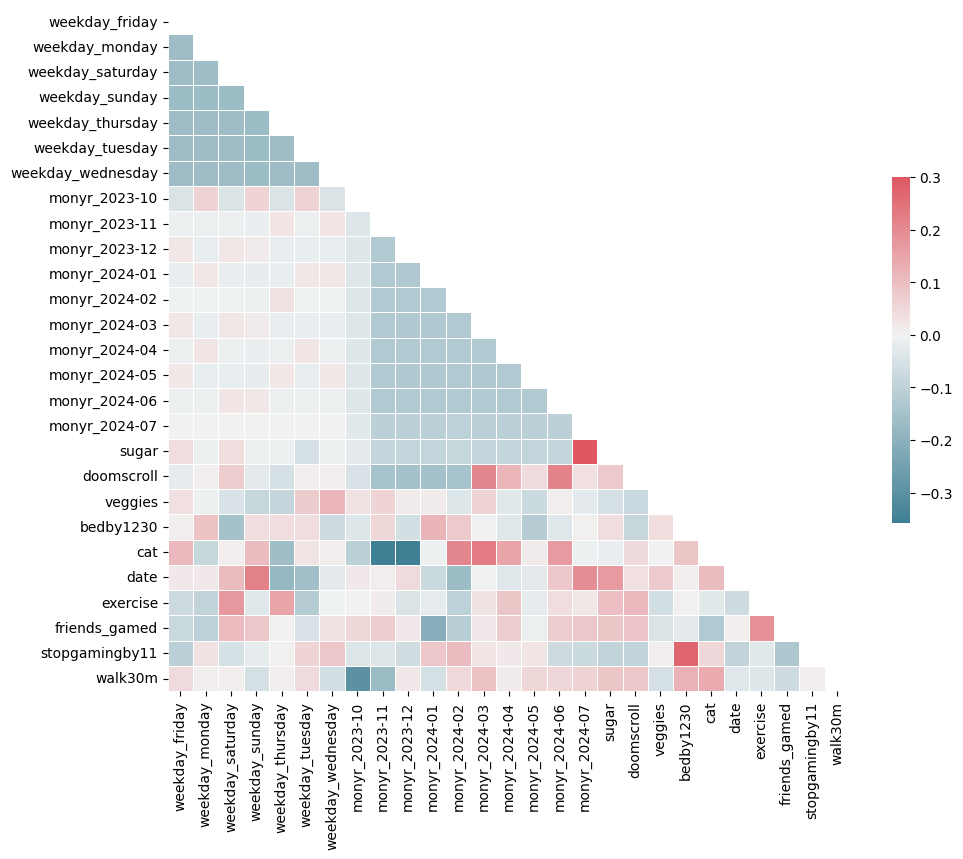

In [70]:
## Check correlations, if <= 0.3 we should be good / not worried about multicollinearity

import numpy as np
import matplotlib.pyplot as plt
## seaborne correlation map
import seaborn as sns

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


## Nothing too crazy here, < 0.3 abs value correlation, so we're good with results as is (above with model output)
## Lol notes:
## Lots of sugar in July (because that's around when I started tracking it)
## Less cat time in Nov/December since we got our cat in January.

### Modeling (Linear regression, feature importance)

In [71]:
## SM has the more standard R output of model results. Whereas Sklearn is more about ML/predictions
import statsmodels.api as sm
model = sm.OLS(Y, sm.add_constant(X)).fit()
coef = model.params
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     3.905
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.40e-08
Time:                        22:36:06   Log-Likelihood:                -213.29
No. Observations:                 267   AIC:                             478.6
Df Residuals:                     241   BIC:                             571.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.8107      0.17

In [72]:
## Iterate a bit to see which vars are the most important if restrictions are placed on the number of vars
from sklearn.linear_model import Lasso
## Larger the alpha, the higher the cutoff for variables (ie less variables) -- trying a few
lassoReg = Lasso(alpha=0.015)
res = lassoReg.fit(X,Y)
la = res.coef_.tolist()
fmt = '{:<8}{:<30}{}'

print(fmt.format(' ', 'Variable', 'Lasso_coef'))
for i, (name, grade) in enumerate(zip(X, la)):
    print(fmt.format(i, name, grade))

        Variable                      Lasso_coef
0       weekday_friday                -0.0
1       weekday_monday                0.0
2       weekday_saturday              0.17596799266464147
3       weekday_sunday                0.02208874583650234
4       weekday_thursday              -0.013959527052783695
5       weekday_tuesday               -0.0
6       weekday_wednesday             -0.0
7       monyr_2023-10                 -0.0
8       monyr_2023-11                 -0.24196686425808572
9       monyr_2023-12                 0.0
10      monyr_2024-01                 0.0
11      monyr_2024-02                 -0.0
12      monyr_2024-03                 -0.0
13      monyr_2024-04                 0.0
14      monyr_2024-05                 0.0
15      monyr_2024-06                 0.0037148578051452302
16      monyr_2024-07                 0.0
17      sugar                         0.0
18      doomscroll                    0.0
19      veggies                       -0.031313407849243954
20

In [73]:
## Key variables
## The constant is the most important (from summary stats above lasso here), meaning I have a generally decent mood to start.
## Exercise has the best effect on my mood for the night I record it it would seem (0.33 coeff in lasso, 0.4 in reg).
## Next is a date/quality time with my partner that gives me a mood boost.
## Also Saturday (which has a slightly positive corr with exercise), then Sunday and a slight negative on Thursday (but p-value is a bit weak).
## Then walking 30min and cat cuddle time are close and the next positives.

## Gaming, stop gaming at 111, veggies, bed by 1230, doomscrolling, suagar are less important.
## June was a pretty good month, November was a bit rough (also when I started recording daylio data so it fits).
## I tend to be happier on Saturdays and a bit more positive on Sunday than avg (tues can be a bit rough) and then Friday is my next favorite lol

In [74]:
coef.sort_values()
## Veggiest are negative for some reason (but likely noise / correlated with something else perhaps - standard error is high).
## Friends gaming, bed by 1230 are also negative, but again might be noise AND might help with future dates.

## Still, interesting to look by positive coefficients ranked: a constant, Saturday, exercise, Sunday, Monday are my top.
## Jan was great (When we got our cat) as well as June. Walking 30m is positive.
## as is cat/dates. sugar, Doomscrolling/stop gaming at 11 is surprisingly weak but might help in the future
## Also I added sugar late so we'll see on that one! Not actually 0 before June so much as non existent.

veggies             -0.192120
friends_gamed       -0.094034
monyr_2023-11       -0.079808
bedby1230           -0.054714
sugar                0.010087
monyr_2024-03        0.043836
monyr_2024-02        0.056964
doomscroll           0.094257
stopgamingby11       0.095533
weekday_thursday     0.116117
weekday_tuesday      0.151135
weekday_wednesday    0.161370
date                 0.178898
cat                  0.188681
monyr_2024-04        0.190720
weekday_friday       0.217064
monyr_2024-07        0.230992
monyr_2024-05        0.241198
monyr_2023-10        0.254729
monyr_2023-12        0.274251
walk30m              0.280437
monyr_2024-06        0.298648
monyr_2024-01        0.299218
weekday_monday       0.309422
weekday_sunday       0.361748
exercise             0.400295
weekday_saturday     0.493891
const                1.810746
dtype: float64

In [75]:
## Checking dates when data start
df_check = pd.concat([df2['full_date'], df_split2], axis=1)
#print(df_check.head())
for x in df_check.columns:
  print(x)
  print(df_check.groupby(x)['full_date'].min().iloc[1])

## recording 'sugar' started 7/4, so not much data.
## doomscroll starting 3/18.
## Cat cuddles stated 1/10, which makes sense since that's the day we got him
## Most of the rest started around when I started daylio, ie late Oct/early Nov.

full_date
2023-10-30
sugar
2024-07-04
doomscroll
2024-03-18
veggies
2023-10-29
bedby1230
2023-10-30
cat
2024-01-10
date
2023-10-29
exercise
2023-10-30
friends_gamed
2023-10-29
stopgamingby11
2023-10-30
walk30m
2023-11-06


In [76]:
## Summarizing with stepwise
## Stepwise function isn't as efficient with a LOT of variables (unlike lasso)

#import statsmodels.api as sm
#import pandas as pd

# Add a constant term to the feature matrix
X_with_const = sm.add_constant(X)

# Stepwise forward selection
def stepwise_selection(X, y,
                       initial_list=[],
                      #  threshold_in=0.01,
                      #  threshold_out=0.05,
                       threshold_in=0.1,
                       threshold_out=0.1,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')  # Explicitly set dtype to 'float64'
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add 1 feature: {best_feature}, p-value: {best_pval:.4f}')

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop 1 feature: {worst_feature}, p-value: {worst_pval:.4f}')

        if not changed:
            break

    return included

# Perform stepwise forward and backward selection
selected_features = stepwise_selection(X, Y)

# Print the final selected features
print("Selected Features:", selected_features)

# Train the model using the selected features
final_model = sm.OLS(Y, sm.add_constant(X[selected_features])).fit()

# Print the summary of the final model
print(final_model.summary())

## Stepwise (0.01 in, 0.05 out). November Sucked - but it's also around when I started tracking my mood so that could be something.
## But Saturdays, Exercise, and Dates are key.

## Switching to 0.1 threshold.
## Same as above, but walking 30min, Cat cuddles help my mood - veggies hurts but I am not sure on how to understand that one...

Add 1 feature: exercise, p-value: 0.0000
Add 1 feature: monyr_2023-11, p-value: 0.0000
Add 1 feature: date, p-value: 0.0002
Add 1 feature: weekday_saturday, p-value: 0.0078
Add 1 feature: walk30m, p-value: 0.0108
Add 1 feature: cat, p-value: 0.0549
Add 1 feature: veggies, p-value: 0.0791
Selected Features: ['exercise', 'monyr_2023-11', 'date', 'weekday_saturday', 'walk30m', 'cat', 'veggies']
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     12.26
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           1.57e-13
Time:                        22:36:10   Log-Likelihood:                -220.50
No. Observations:                 267   AIC:                             457.0
Df Residuals:                     259   BIC:        

#### Modeling - feature contribution to the NEXT day's mood

In [77]:
## Let's try to predict the next day.

## Shift Y up 1 day, drop last value
Y2 = Y.shift(-1).dropna()
print(Y2.head())
print(Y.head())
## Drop last X value
X2 = X.iloc[:-1]

0    3.0
1    2.0
2    2.0
3    2.0
4    1.0
Name: mood, dtype: float64
0    3
1    3
2    2
3    2
4    2
Name: mood, dtype: int64


In [78]:
## SM has the more standard R output of model results. Whereas Sklearn is more about ML/predictions
model = sm.OLS(Y2, sm.add_constant(X2)).fit()
coef = model.params
print(model.summary())

## R-squared goes down from 0.29 (0.25 stepwise) to 0.197, so less explanatory but still okay to interpret

                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     2.363
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           0.000454
Time:                        22:36:11   Log-Likelihood:                -228.79
No. Observations:                 266   AIC:                             509.6
Df Residuals:                     240   BIC:                             602.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.3571      0.19

In [79]:
## Summarizing with stepwise
## Stepwise function isn't as efficient with a LOT of variables (unlike lasso)


#import statsmodels.api as sm
#import pandas as pd

# Add a constant term to the feature matrix
X_with_const = sm.add_constant(X2)

# Stepwise forward selection
def stepwise_selection(X, y,
                       initial_list=[],
                      #  threshold_in=0.01,
                      #  threshold_out=0.05,
                       threshold_in=0.1,
                       threshold_out=0.1,
                       verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # Forward step
        excluded = list(set(X2.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')  # Explicitly set dtype to 'float64'
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add 1 feature: {best_feature}, p-value: {best_pval:.4f}')

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop 1 feature: {worst_feature}, p-value: {worst_pval:.4f}')

        if not changed:
            break

    return included

# Perform stepwise forward and backward selection
selected_features = stepwise_selection(X2, Y2)

# Print the final selected features
print("Selected Features:", selected_features)

# Train the model using the selected features
final_model = sm.OLS(Y, sm.add_constant(X[selected_features])).fit()

# Print the summary of the final model
print(final_model.summary())

## Stepwise (0.01 in, 0.05 out). November Sucked - but it's also around when I started tracking my mood so that could be something.
## But Saturdays, Exercise, and Dates are key.

## Switching to 0.1 threshold.
## Same as above, but walking 30min, Cat cuddles help my mood - veggies hurts but I am not sure on how to understand that one...
## Might just be that veggies is so common it's effectively just noise (ie did I eat veggies that day).

Add 1 feature: monyr_2023-11, p-value: 0.0000
Add 1 feature: weekday_sunday, p-value: 0.0002
Add 1 feature: monyr_2024-02, p-value: 0.0274
Add 1 feature: weekday_monday, p-value: 0.0309
Add 1 feature: veggies, p-value: 0.0459
Selected Features: ['monyr_2023-11', 'weekday_sunday', 'monyr_2024-02', 'weekday_monday', 'veggies']
                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     5.003
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           0.000215
Time:                        22:36:13   Log-Likelihood:                -246.48
No. Observations:                 267   AIC:                             505.0
Df Residuals:                     261   BIC:                             526.5
Df Model:                           5    

In [80]:
## For predicting the NEXT day ## there is a high constant, so less is predictive, also R^2 drops to 0.087 for stepwise, so it all counts..
## and explanability is low.
## Nove/Feb aren't very useful. Sunday and Mon aren't that actionable and veggies is still negative.. so not sure here.

In [81]:
coef.sort_values()
## This is noisy, given low p-values, but still fun to explore.
## Monday is a good predictor of the next day's mood...? Looks like my actions are almost all negative/not very predictive.
## I know from anecdotal experience, sleep helps... and that does seem to be the strongest after stop gaming by 11 (which is an input)
## Since if I stop gaming at 11 it's easier to go to bed by 1230.

## So my takeaway here is that sleep + stop gaming at 11 is my best indicator for my next day's mood.
## And my same day mood is mostly affected by Exercise, dates, cat time, and walking 30m.

veggies             -0.285924
monyr_2023-11       -0.250471
cat                 -0.134819
exercise            -0.118340
friends_gamed       -0.073226
sugar               -0.061201
date                -0.003516
doomscroll           0.001621
stopgamingby11       0.008973
walk30m              0.037581
monyr_2024-02        0.066493
monyr_2023-10        0.077336
bedby1230            0.096176
monyr_2023-12        0.164178
weekday_friday       0.193713
weekday_wednesday    0.198433
weekday_thursday     0.199986
monyr_2024-03        0.283279
weekday_saturday     0.324924
weekday_tuesday      0.332173
monyr_2024-01        0.332853
monyr_2024-05        0.336553
monyr_2024-04        0.393348
weekday_monday       0.428738
monyr_2024-07        0.428790
monyr_2024-06        0.524779
weekday_sunday       0.679170
const                2.357137
dtype: float64

In [82]:
## Let's try to predict the day after?

## Shift Y up 1 day, drop last value
Y3 = Y.shift(-2).dropna()
## Drop last X value
X3 = X.iloc[:-2]

In [83]:
## SM has the more standard R output of model results. Whereas Sklearn is more about ML/predictions
model = sm.OLS(Y3, sm.add_constant(X3)).fit()
coef = model.params
print(model.summary())

## R-squared goes down from 0.29 (0.25 stepwise) to 0.197, so less explanatory but still okay to interpret

                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2.319
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           0.000601
Time:                        22:36:16   Log-Likelihood:                -228.63
No. Observations:                 265   AIC:                             509.3
Df Residuals:                     239   BIC:                             602.3
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.1459      0.19

In [84]:
## 2 days ahead is comparable to 1 day ahead R square, but not super helpful for features - lots of negatives that don't really make sense.
## (eg walking 30m makes me have a worse mood 2 days later...?)

coef.sort_values()
## Similarly, low p-values, so likely noise, but besides weekdays/months - the closest positive is sleep/stop gaing at 11 (related).
## So 2 days out has similar takeaways to 1 day out effectively

monyr_2023-10       -0.689506
walk30m             -0.229258
monyr_2023-11       -0.141084
sugar               -0.105612
friends_gamed       -0.073563
exercise            -0.042014
date                -0.019441
veggies             -0.006760
cat                  0.011492
doomscroll           0.013088
monyr_2024-02        0.023841
bedby1230            0.072336
stopgamingby11       0.126380
weekday_thursday     0.146429
weekday_saturday     0.184223
weekday_friday       0.187487
weekday_sunday       0.248808
weekday_wednesday    0.302359
monyr_2024-03        0.307131
monyr_2023-12        0.320119
monyr_2024-01        0.381444
monyr_2024-04        0.399261
monyr_2024-05        0.404417
weekday_tuesday      0.444652
monyr_2024-06        0.539966
monyr_2024-07        0.600315
weekday_monday       0.631945
const                2.145903
dtype: float64

In [85]:
## For stupid/silly reasons - predicting the previous day to see if anything happens
Yn = Y.shift(1).dropna()
## Drop last X value
Xn = X.drop(0)

## SM has the more standard R output of model results. Whereas Sklearn is more about ML/predictions
model = sm.OLS(Yn, sm.add_constant(Xn)).fit()
coef = model.params
print(model.summary())

## R-squared is the lowest (0.178) but still decent honestly for what this is....
## Constant matters, similar to month, etc which makes sense. The rest is likely noise...
## So below is gibberish but I was just curious what it would look like - can I predict the past?! Not really

                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     2.084
Date:                Tue, 23 Jul 2024   Prob (F-statistic):            0.00256
Time:                        22:36:19   Log-Likelihood:                -231.62
No. Observations:                 266   AIC:                             515.2
Df Residuals:                     240   BIC:                             608.4
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9523      0.19

#### Modeling - upsampling minority class (ie more emphasis on bad/great moods)

In [113]:
## check mood distribution
full_data = df_combined.drop(['activities'],axis=1)
print(full_data['mood'].value_counts())
#full_data.head()

mood
3    157
2     87
1     12
4     11
Name: count, dtype: int64


In [114]:
## upsample minority classes (Mood = 1, 4) - resampling to even out mood distributions
from sklearn.utils import resample
df_majority = full_data[full_data['mood'].isin([2,3])]
df_minority = full_data[full_data['mood'].isin([1,4])]

df_minority_upsampled = resample(df_minority,
                                 replace=True,      # sample with replacement
                                 n_samples=len(df_majority), # to match majority class
                                 random_state=123)  # reproducible results

df_upsampled = pd.concat([df_majority, df_minority_upsampled])


## Much more weight now on 1 & 4 moods
## 2&3 = 157+87 = 244
## 1&4 = 131+113 = 244
print(df_upsampled['mood'].value_counts())

mood
3    157
4    131
1    113
2     87
Name: count, dtype: int64


In [106]:
Xr = df_upsampled.drop(['mood'],axis=1)
Xrs = Xr.apply(pd.to_numeric, errors='coerce')
Yr = df_upsampled.mood
Yrs = Yr.apply(pd.to_numeric, errors='coerce')

In [100]:
131+113

244

In [107]:
model = sm.OLS(Yrs, sm.add_constant(Xrs)).fit()
coef = model.params
print(model.summary())
## WOW R-square goes to 0.7 (instead of 0.29 highest above).
## Lots of explanable variation! Granted we're resampling 11-12 mood 1-4 like 10x randomly

                            OLS Regression Results                            
Dep. Variable:                   mood   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     43.46
Date:                Tue, 23 Jul 2024   Prob (F-statistic):          1.20e-104
Time:                        23:02:23   Log-Likelihood:                -448.60
No. Observations:                 488   AIC:                             949.2
Df Residuals:                     462   BIC:                             1058.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.7586      0.14

In [108]:
## Constant is largest + lowest p-value, then Saturday close behind (fits earlier)
## then exercise (So similar to above analysis).
## cat, dates, walk30m are a lot closer now, whereas other models walk30m was higher.
## Main takeaway: So REALLY good/bad days social connection becomes more important (cat/dates).

## Suprisingly friends_gamed is negative (probably a not great sign) - but so are veggies... so...
## doomscroll is a bit positive (ie no doomscroll = good!)
##
coef.sort_values()

friends_gamed       -0.396093
veggies             -0.281533
monyr_2024-03       -0.161672
bedby1230           -0.144086
monyr_2023-11       -0.123697
weekday_thursday    -0.081004
monyr_2024-02       -0.024473
weekday_tuesday      0.020751
stopgamingby11       0.037790
monyr_2024-05        0.047963
weekday_friday       0.095448
weekday_wednesday    0.144200
monyr_2024-01        0.206385
doomscroll           0.217835
monyr_2024-07        0.228413
monyr_2024-04        0.253809
weekday_monday       0.286721
sugar                0.315648
monyr_2023-12        0.333619
date                 0.346711
walk30m              0.365283
cat                  0.373138
monyr_2024-06        0.402294
weekday_sunday       0.497707
monyr_2023-10        0.595927
exercise             0.683387
weekday_saturday     0.794743
const                1.758567
dtype: float64

In [111]:

## Larger the alpha, the higher the cutoff for variables (ie less variables) -- trying a few
lassoReg = Lasso(alpha=0.05)
res = lassoReg.fit(Xrs,Yrs)
la = res.coef_.tolist()
fmt = '{:<8}{:<30}{}'

print(fmt.format(' ', 'Variable', 'Lasso_coef'))
for i, (name, grade) in enumerate(zip(Xrs, la)):
    print(fmt.format(i, name, grade))

        Variable                      Lasso_coef
0       weekday_friday                -0.0
1       weekday_monday                0.0
2       weekday_saturday              0.5034252957890754
3       weekday_sunday                0.0
4       weekday_thursday              -0.1008158391576255
5       weekday_tuesday               -0.0
6       weekday_wednesday             -0.0
7       monyr_2023-10                 0.0
8       monyr_2023-11                 -0.039924369698819864
9       monyr_2023-12                 0.0
10      monyr_2024-01                 0.0
11      monyr_2024-02                 -0.0
12      monyr_2024-03                 -0.0
13      monyr_2024-04                 0.0
14      monyr_2024-05                 -0.0
15      monyr_2024-06                 0.0
16      monyr_2024-07                 0.0
17      sugar                         0.0
18      doomscroll                    0.0
19      veggies                       -0.16518074098800836
20      bedby1230                     -

In [112]:
## Feature importance, for higher lasso threshold. We see the key variables
## Exercise is still first (largest coeff), but date becomes more important (then cat and later walks)
## This re-enforces that really good/bad days - dates are more essential.
## Also I really like saturdays haha, less so Thursdays (and Nov was rough).
## Maybe I'll never understand why veggies are negative...